# Using guitar CNN model
## モデルの精度を実際に演奏しながら確かめるために使用
- 20231104_CNN_guitar_testで学習したモデルを実際の演奏で使用してみる

- モデルのテスト./../models/guitar_.08_0.0511_0.9567.hdf5
    - モデルの学習データのセッティング
        - コントロールノブ
            - TONE：0
            - VOLUME：10
        - EVO4 VOLUME：12メモリ
        - ピックアップ
            - リアピックアップ
  
    - コントロールノブの影響
        - TONE：影響なし
        - VOLUME：影響あり
            - 6にするとbadしか出なくなった
            - EVO4のVOLUMEを大きくしても6の時はGoodが出なかった
    - ピックアップ
        - フロントは変化なし
        - ハーフだとBadしか出ない
    - EVO4 VOLUME
        - 変化なし
        - そもそもVOLUMEを変えて録音してみても変化していない
        - 自動で調整されているのかもしれない

## ライブラリのインポート

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import sounddevice as sd
import librosa
import librosa.display

import tensorflow
from tensorflow import keras
from keras.models import load_model

## モデルのロード

In [2]:
model = load_model("./../models/guitar_.08_0.0511_0.9567.hdf5")

## インプットデバイスとアウトプットデバイスの確認

In [3]:
print(f"Input: {sd.query_devices(kind='input')['name']}")
print(f"output: {sd.query_devices(kind='output')['name']}")

Input: Mic | Line 1/2 (Audient EVO4)
output: Speaker (Realtek(R) Audio)


## 各種関数の定義

In [5]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

## 演奏の録音と再生をした後に波形データとメルスペクトログラムを表示する

wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


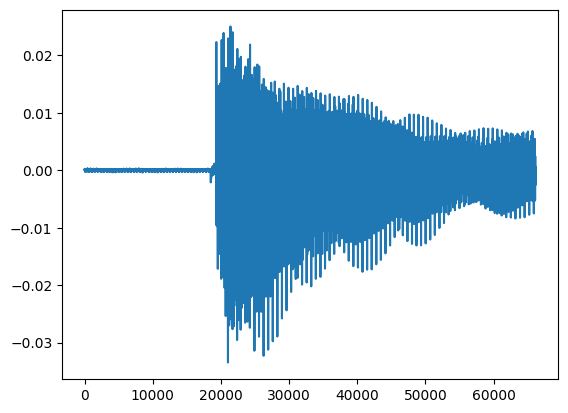

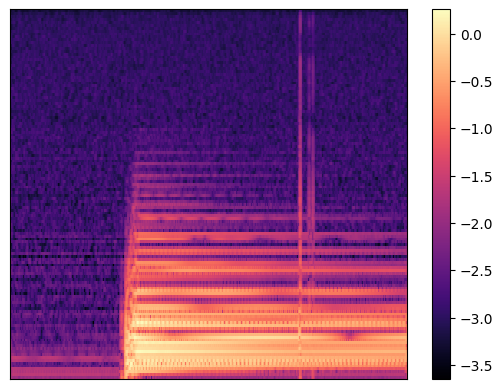

In [167]:
fs = 22050
sd.default.device = [1, 10]

duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

sd.play(data, fs)

data.reshape(len(data)).shape

x = data.reshape(len(data))
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

## 演奏を録音してモデルで評価

In [135]:
fs = 22050
sd.default.device = [1, 10]
duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

x = data.reshape(len(data))
melsp = calculate_melsp(x)

pred = model.predict(melsp.reshape(1, 128, 517, 1))
pred_label = np.argmax(pred)

print(pred_label)

if pred_label == 0:
    print("good!!")
elif pred_label == 1:
    print("normal")
elif pred_label == 2:
    print("bad!!")

1/1 [==============================] - 0s 18ms/step
2
bad!!
